In [41]:
from gensim.models.fasttext import FastText 
import matplotlib.pyplot as plt
from sklearn.pipeline import  FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report

import pandas as pd
import re
import numpy as np
import gensim

In [13]:
#!pip install gensim==3.6.0

     |████████████████████████████████| 23.1 MB 11.8 MB/s eta 0:00:01
  Created wheel for gensim: filename=gensim-3.6.0-cp38-cp38-macosx_10_9_x86_64.whl size=23493029 sha256=25b57e041f034b0cdc7e2f400ab69cb62f811bd7104077522b5afe11e27dbf3e
  Stored in directory: /Users/ktyser/Library/Caches/pip/wheels/d6/5b/91/658efb08f9d790987e1ef3795e62e129868afb0fde409baac5
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1


In [2]:
training_set = pd.read_csv("Train.csv")
training_set.sample(5)

,ID,Text,Label
383,ID_OovlfDsa,Amayi Ozembetsa Mankhwala Ozunguza Bongo Apats...,LAW/ORDER
566,ID_UxhjvJCs,HRDC Yachita Ziwonetsero Zokwiya ndi Kusankhid...,POLITICS
858,ID_fcYSPfnp,Kusanthula chaka cha ulamuliro wa JB Pamene d...,POLITICS
1100,ID_pPLWlAov,Parishi ya Kausi Ichita Chaka cha Nkhoswe Yake...,RELIGION
655,ID_YqtxKtNT,Kodi Idrissa Walesi akutani mu Mozambique? Mu...,SOCIAL ISSUES


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1436 non-null   object
 1   Text    1436 non-null   object
 2   Label   1436 non-null   object
dtypes: object(3)
memory usage: 33.8+ KB


In [4]:
test_set = pd.read_csv("Test.csv")
test_set.sample(5)

,ID,Text
186,ID_OSdWloXg,Mvula Iwononga Nyumba za Chipatala cha Pirimit...
491,ID_pqokbYlh,K10 000 kwa ophunzitsa kumidzi Aphunzitsi aku...
244,ID_UdCMVMtC,Akumanga mvula ndani? Tsikulo pa Wenela padal...
106,ID_IOaQZPeL,Mfumu Ilipira 50 Sauzande Kaamba Kochitira Umb...
32,ID_CWcVYAQq,Five Questions for Minister of Transport and ...


Text(0.5, 1.0, 'Classes distribution')

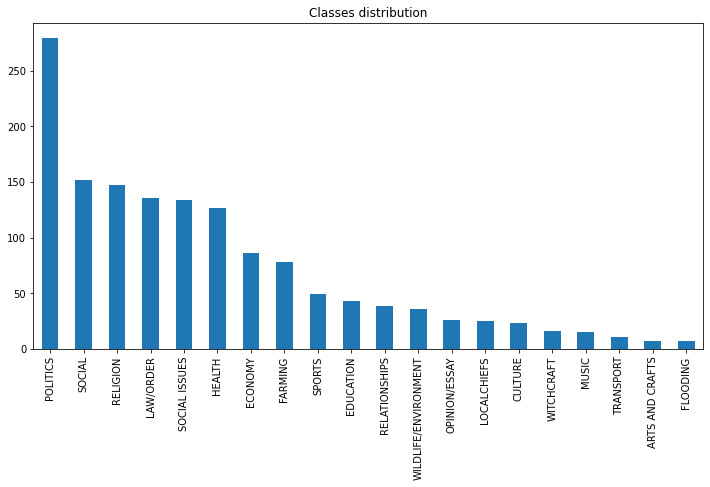

In [5]:
training_set.Label.value_counts().plot.bar(figsize=(12, 6))
plt.title('Classes distribution')

In [6]:
def preprocess_text(doc):
    # remove punctuation signs and multiple spaces
    regex_punc = re.compile('[%s]'%re.escape('.,!?'))
    doc = re.sub( regex_punc, ' ',doc)
    doc = doc.strip().lower() 
    regex_seq_spaces = re.compile(' {2,}')
    doc = re.sub( regex_seq_spaces, ' ',doc)
    return doc

In [7]:
# testing function
sample_text = training_set.Text[7]
print("RAW text before preprocessing :\n")
print(sample_text)
print("\n-------------------------------\n")
print("Processed text after preprocessing :\n")
print(preprocess_text(sample_text))

RAW text before preprocessing :

 Mayi wamalonda avulazidwa ku bt Titha Masamba, wa zaka 31, akumva ululu wadzaoneni. Kuti ayende akuyenera agwirire ndodo; sangagone chafufumimba koma chammbali kapena chagada; moyo wamtendere watha.
 Akuti adamuphera tsogolo lake: Masamba kumva ululu kunyumba kwake Akuti izitu zili chonchi chifukwa cha bala lomwe lili pabondo lake la kumanja lomwe lidasokedwa kuchipatala pambuyo pokhapidwa ndi chikwanje.
  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Pa Wenela pasintha zedi Ulendo wa mayiyu wokagulitsa mandasi pa 7 July ndi womwe udabweretsa mavutowa pomwe anthu ena, omwe akuwaganizira kuti ogwira ntchito kukhonsolo ya mzinda wa Blantyre (city rangers) amene adamuchita chiwembu pomulanda malonda ake komanso kumuvulaza ndi chikwanje.
 Masamba akuti atangomwalira amuna ake mu 2007, iye adayamba geni yogulitsa mandasi kuti azisamalira banja lake la ana awiri. Malo amene amagulitsira malonda akewo akuti ndi ku Cold Storage pafupi 

In [8]:
# Applying the preprocessing function to all the data
training_set['text'] = training_set.Text.apply(lambda x: [i for i in preprocess_text(x).split() if len(i) > 1])
test_set['text'] = test_set.Text.apply(lambda x: [i for i in preprocess_text(x).split() if len(i) > 1])

In [21]:
%%time
model = FastText(training_set.text.to_list() + test_set.text.to_list() , vector_size=60, window=30, min_count=1, workers=12, epochs=20, sg=1, bucket=400_000)
model.save('ft.model')

CPU times: user 15min 57s, sys: 3.19 s, total: 16min
Wall time: 1min 38s


In [22]:
# get a word embedding vector for an example word
print(model.wv.get_vector("happy"))
model.wv.get_vector("happy").shape

[-1.1344559  -0.05896131  0.10070355 -1.150928   -0.80239326 -0.9610367
  0.8016022  -0.06940264 -0.3817841   0.59534043  0.72112375  0.3565281
  0.34366888 -0.7625204   0.20328753 -0.54765856  1.2764324  -0.55679107
 -1.1622101   0.46273798  0.87525547 -1.3746036  -0.08134372  0.36066857
  0.09062533  0.9188185  -0.76268137  0.45951357  1.9029156   0.793038
 -0.20951737  0.7927655   1.0101088   0.2526336  -0.8748075  -0.19197136
 -0.35172042  0.5456543   0.32466117  0.49213445  0.9249611   0.42308444
  0.51993734  0.7997143   0.41424572 -0.8538886   0.24801542 -0.4759442
 -0.3412909  -0.31946895  0.31422886  0.25350598  0.65463537  0.648164
  0.29386535  1.6037717   0.02594591  0.7831965   0.7295738  -0.33062547]


(60,)

Function generates average representation of a given text into a vector because the model above only transforms one unigram to a vector. 

In [23]:
def word_averaging(wv, words):
    mean = np.zeros((wv.vector_size,))
    
    for word in words:
        mean += wv.get_vector(word)

    mean = gensim.matutils.unitvec(mean)
    return mean

In [24]:
# testing function
word_averaging(model.wv, ["i", "like", "meat"])

array([-0.42901575, -0.15721782, -0.09832981, -0.15174854,  0.04038237,
       -0.12917622,  0.06548765,  0.0152512 ,  0.15458459,  0.20261953,
        0.17487602, -0.02050153, -0.01141026, -0.0684574 ,  0.05092847,
        0.18801742,  0.02274622,  0.11765056, -0.06166138,  0.12922386,
       -0.16007561,  0.03954301, -0.05663066, -0.07642238, -0.22853368,
        0.00861114, -0.1521249 , -0.02808724,  0.01806685,  0.06818171,
       -0.11411308,  0.23352581, -0.08035794, -0.05699651, -0.00969199,
       -0.01927954,  0.00904784,  0.03047667,  0.19532001,  0.03199489,
       -0.18076315,  0.03687976,  0.15122112,  0.16156547, -0.091726  ,
       -0.17004855,  0.06112872,  0.07224401, -0.1880949 ,  0.14552904,
        0.07561383,  0.20159188, -0.0343817 , -0.1776177 , -0.05845145,
        0.10364227, -0.15071329,  0.10062381,  0.03133141,  0.11767174])

In [29]:
# create a union of 3 features combined between fasttext representation and tfidf 
union = FeatureUnion([
    ("char15", TfidfVectorizer(ngram_range =(1,5), analyzer='char_wb',stop_words=['ndi'],max_df = 0.2 ,min_df = 0.0 , 
                             max_features = 10000)),
    ("word12", TfidfVectorizer(ngram_range =(1,2), stop_words=['ndi'], max_df = 0.15 ,min_df = 0.01 ,
                             max_features = 5000)), 
    ('fast_vec', FunctionTransformer(lambda df: df.apply(lambda x: word_averaging(model.wv,[i for i in preprocess_text(x).split() if len(i) > 1])).tolist(),
                                              validate=False))
  ])

Training model

In [30]:
%%time
pipe = Pipeline([
    ('feats', union),
    ('clf', LogisticRegression(C = 5, solver = 'liblinear', class_weight='balanced'))
])

CPU times: user 96 µs, sys: 1 µs, total: 97 µs
Wall time: 100 µs


Classification report and confusion matrix

In [43]:
predicted = cross_val_predict(pipe, training_set['Text'], training_set['Label'], cv=5)
print(classification_report(training_set['Label'], predicted))

                      precision    recall  f1-score   support

     ARTS AND CRAFTS       0.40      0.29      0.33         7
             CULTURE       0.40      0.35      0.37        23
             ECONOMY       0.41      0.41      0.41        86
           EDUCATION       0.77      0.79      0.78        43
             FARMING       0.78      0.90      0.83        78
            FLOODING       0.71      0.71      0.71         7
              HEALTH       0.73      0.72      0.73       127
           LAW/ORDER       0.60      0.65      0.63       136
         LOCALCHIEFS       0.50      0.60      0.55        25
               MUSIC       0.67      0.53      0.59        15
       OPINION/ESSAY       0.00      0.00      0.00        26
            POLITICS       0.76      0.77      0.76       279
       RELATIONSHIPS       0.86      0.97      0.92        39
            RELIGION       0.69      0.75      0.72       147
              SOCIAL       0.57      0.49      0.53       152
       

Reporting 5 fold cv f1 score and accuracy

In [37]:
f1 = cross_val_score(pipe, training_set['Text'], training_set['Label'], cv=StratifiedKFold(5, shuffle=True, random_state=777),scoring='f1_weighted')
print(f1,'\n mean:{:.3f} std :{:.3f}'.format(f1.mean(),f1.std()))

acc = cross_val_score(pipe, training_set['Text'], training_set['Label'], cv=StratifiedKFold(5, shuffle=True, random_state=777),scoring='accuracy')
print(acc,'\n mean:{:.3f} std :{:.3f}'.format(acc.mean(),acc.std()))


[0.61557166 0.61960671 0.64983826 0.66004403 0.65209181] 
 mean:0.639 std :0.018
[0.62847222 0.63414634 0.66202091 0.67595819 0.65853659] 
 mean:0.652 std :0.018


Making preds on test set

In [32]:
pipe.fit( training_set['Text'], training_set['Label'])

test_set.loc[:,"Label"] = pipe.predict(test_set['Text'])

In [33]:
test_set[['ID','Label']]

,ID,Label
0,ID_ADHEtjTi,SOCIAL ISSUES
1,ID_AHfJktdQ,RELIGION
2,ID_AUJIHpZr,RELATIONSHIPS
3,ID_AUKYBbIM,SOCIAL ISSUES
4,ID_AZnsVPEi,HEALTH
...,...,...
615,ID_zdpOUWyJ,LAW/ORDER
616,ID_zhnOomuu,RELATIONSHIPS
617,ID_zmWHvBJb,LAW/ORDER
618,ID_zphjdFIb,CULTURE


In [61]:
# extract to csv
#test_set[['ID','Label']].to_csv("submission.csv",index=False) 